# 차근차근 딥러닝 Part 04. 딥러닝 회귀 - Step 05. 딥러닝 회귀 실습

## 1. Data 로딩

In [1]:
from sklearn.datasets import load_boston
boston_house = load_boston()

## 2. 전처리
- pandas를 이용하여 데이터를 로딩하고, 설명변수와 타겟변수를 합치기
- StandardScaler를 이용하여 정규화 해주기(이때 타켓 변수는 제외)

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(boston_house.data, columns=boston_house.feature_names)

# 데이터 정규화
scaler = StandardScaler()
scaler.fit(df.values[:,:])
df.values[:,:] = scaler.transform(df.values[:,:])

# 타겟 변수를 마지막에 추가하기
df['TARGET'] = boston_house.target
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,22.4
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,20.6
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,23.9
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,22.0


## 3. 데이터셋 분할 $\to$ Train, Valid, Test

In [3]:
import torch
data_numpy = torch.from_numpy(df.values).float()

In [4]:
x = data_numpy[:, :-1] # 독립 변수
y = data_numpy[:, -1:] # 타겟 변수
print(x.shape, y.shape)

torch.Size([506, 13]) torch.Size([506, 1])


In [5]:
# Train / Validation / Test 분할 비율
split_ratio = [0.6, 0.2, 0.2]

In [6]:
# 분할 데이터별 필요한 데이터 수 설정
train_cnt = int(data_numpy.size(0) * split_ratio[0])
valid_cnt = int(data_numpy.size(0) * split_ratio[1])
test_cnt = data_numpy.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

# 분할 결과를 확인하기 위해 화면에 출력
print("Train: {}, Valid: {}, Test: {} samples.".format(
                                train_cnt, 
                                valid_cnt, 
                                test_cnt)
     )


Train: 303, Valid: 101, Test: 102 samples.


In [7]:
### 랜덤하게 데이터를 추출하여 Train / Validation / Test 구성 ###

# 데이터 갯수 만큼 랜덤하게 인덱스 번호 생성
indices = torch.randperm(data_numpy.size(0))

# 독립변수(x)와 타겟변수(y)로부터 랜덤하게 생성한 인덱스(indices) 순서대로 추출
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# Train / Validation / Test 분할 비율에 맞게 데이터 분할
x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

# 분할된 데이터셋 크기 확인
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([303, 13]) torch.Size([303, 1])
torch.Size([101, 13]) torch.Size([101, 1])
torch.Size([102, 13]) torch.Size([102, 1])


In [8]:
x[0].shape, y[0].shape

(torch.Size([303, 13]), torch.Size([303, 1]))

## 4.1. 딥러닝 모델 생성 1. Pytorch의 nn.Module 활용하는 방법

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 딥러닝 모델 생성 1. Pytorch의 nn.Module 활용하는 방법
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim # 입력 차원
        self.output_dim = output_dim # 출력 차원
        
        super().__init__() # 부모 클래스 __init__ 보호
        
        # 은닉층(Hidden Layer) 설계
        self.linear1 = nn.Linear(input_dim, 32)
        self.linear2 = nn.Linear(32, 16)
        self.linear3 = nn.Linear(16, 8)
        self.linear4 = nn.Linear(8, 4)
        self.linear5 = nn.Linear(4, output_dim)
        self.act = nn.ReLU()
        
    def forward(self, x):
        
        # 객체 호출 시 입력 텐서 크기: |x| = (batch_size, input_dim)
        h = self.act(self.linear1(x)) # |h| = (batch_size, 32)
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        h = self.act(self.linear4(h))
        y = self.linear5(h)
        # 출력텐서 크기: |y| = (batch_size, output_dim)
        
        # 구축된 신경망 반환(return)
        return y

## 4.2 딥러닝 모델 생성 2. Pytorch의 nn.Sequential을 활용하는 방법

In [10]:
# Pytorch의 nn.Sequential을 활용하는 방법
input_dim = x[0].size(-1)
ouput_dim = y[0].size(-1)
model_sequential = nn.Sequential(
    nn.Linear(input_dim, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 5),
    nn.LeakyReLU(),
    nn.Linear(5, ouput_dim),
)

# 네트워크 형태 확인을 위해 화면에 모델을 출력
print(model_sequential)

Sequential(
  (0): Linear(in_features=13, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=5, out_features=5, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=5, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
)


## 5.학습(Train) 함수 작성

In [11]:
# 학습 모델 저장을 위한 deepcopy 라이브러리 임포트
from copy import deepcopy

def train(
    model, # 신경망 모델
    x, # 학습데이트
    y, # 예측값(정답)
    loss_func, # 손실함수
    lr=1e-4, # 학습률
    n_epochs=100, # Epoch 수행 횟수
    batch_size=32, # 미니배치 크기
    print_interval=1000, # 학습결과를 출력하는 간격
):

    lowest_loss = np.inf
    best_model = None
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # GPU 사용이 가능할 경우 사용, 불가능할 경우 CPU 사용
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    
    # 학습 시작 전 모든 값을 지정된 Device로 이동
    model = model.to(device)
    x = [x_i.to(device) for x_i in x]
    y = [y_i.to(device) for y_i in y]
    
    ### 학습 및 검증 시작 ###
    # 학습 진행상태(Loss)를 시각화하기 위한 List todtjd
    train_history = []
    valid_history = []
    
    ### Epoch 시작 ###
    for epoch_index in range(n_epochs):
        
        '''
        우리 예제의 경우 텐서 형태
        x[0]: x_1, y_1 -> torch.Size([303, 13]) torch.Size([303, 1])
        x[1]: x_2, y_2 -> torch.Size([101, 13]) torch.Size([101, 1])
        x[2]: x_3, y_3 -> torch.Size([102, 13]) torch.Size([102, 1])
        '''
        
        train_x, train_y = x[0], y[0]
        valid_x, valid_y = x[1], y[1]
        test_x, test_y = x[2], y[2]
        
        # 미니배치 만들기 x[0], y[0] --> train set
        indices= torch.randperm(train_x.size(0), device=train_x.device)
        train_x = torch.index_select(train_x, dim=0, index=indices)
        train_y = torch.index_select(train_y, dim=0, index=indices)
        train_x_batch = torch.split(train_x, batch_size, dim=0)
        train_y_batch = torch.split(train_y, batch_size, dim=0)
        
        # 개별 |train_x_batch| = (batch_size, input_dim)

        ### Train 데이터 학습 시작 ###
        model.train() # 학습모드 On
        total_loss_train = 0
        for batch_index in range(len(train_x_batch)):
            
            # 텐서 형태
            # |x_i| = (batch_size, 13)
            # |y_i| = (batch_size, 1)
            
            # 전진(forward) 학습 
            y_hat = model(train_x_batch[batch_index])

            # 손실값 계산
            loss = loss_func(y_hat, train_y_batch[batch_index])

            # 미분 수행 (back propagation)
            optimizer.zero_grad() # 기존 미분값이 있다면 초기화
            loss.backward()
        
            # Stochastic Gradient Descent 수행
            optimizer.step()
            
            # Total Loss 업데이트
            total_loss_train += float(loss) 
        
        # 최종 Train Loss 계산 -> Train 종료
        train_loss = total_loss_train / len(train_x_batch)
        
        ### Validation 시작 ###
        model.eval() # 학습모드 off
        with torch.no_grad():
            y_hat = model(valid_x)
            loss = loss_func(y_hat, valid_y)
            valid_loss = loss / len(valid_y)

        # Valid Loss를 확인하여 모델을 저장
        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            best_model = deepcopy(model.state_dict())
            torch.save(
                {
                    'model': best_model,
                    'n_epochs': n_epochs,
                    'batch_size': batch_size,
                    'lr': lr,
                    'optimizer': 'SGD',
                }, 
                'model_regression.pth'
            )
            
        # 1회 epoch 종료 후 Loss 출력
        if (epoch_index + 1) % print_interval == 0:
            print(
                'Epoch({0:2d}/{1:2d}): train_loss={2:8.6f}  valid_loss={3:8.6f}  lowest_loss={4:8.6f}'.format(
                    epoch_index+1, 
                    n_epochs,
                    train_loss,
                    valid_loss,
                    lowest_loss,               
                )
            )

## 6. Train, valid 데이터를 이용하여 학습 진행

In [12]:
# 하이퍼 파라미터
batch_size = 32
n_epochs = 10000
print_interval = 1000
learning_rate = 1e-4
model_MyModel = MyModel(x[0].size(-1), y[0].size(-1))
model_sequential
loss_func = F.mse_loss

### 6.1. nn.Module을 사용한 학습

In [13]:
train(model_MyModel, x, y, loss_func, n_epochs=n_epochs, batch_size=batch_size, print_interval=print_interval)

Epoch(1000/10000): train_loss=3.693047  valid_loss=0.162697  lowest_loss=0.160925
Epoch(2000/10000): train_loss=2.069057  valid_loss=0.154008  lowest_loss=0.151120
Epoch(3000/10000): train_loss=1.219060  valid_loss=0.154911  lowest_loss=0.149705
Epoch(4000/10000): train_loss=0.883124  valid_loss=0.166389  lowest_loss=0.149705
Epoch(5000/10000): train_loss=0.757545  valid_loss=0.171784  lowest_loss=0.149705
Epoch(6000/10000): train_loss=0.583953  valid_loss=0.172766  lowest_loss=0.149705
Epoch(7000/10000): train_loss=0.534458  valid_loss=0.171277  lowest_loss=0.149705
Epoch(8000/10000): train_loss=0.483372  valid_loss=0.174632  lowest_loss=0.149705
Epoch(9000/10000): train_loss=0.414599  valid_loss=0.177102  lowest_loss=0.149705
Epoch(10000/10000): train_loss=0.367553  valid_loss=0.178229  lowest_loss=0.149705


### 6.2. nn.Sequential을 사용한 학습

In [14]:
#train(model_sequencial, x, y, loss_func, n_epochs=n_epochs, batch_size=batch_size, print_interval=print_interval)

## 7. Test 데이터 평가

In [15]:
# n_epochs = check_point['n_epochs']
# batch_size = check_point['batch_size']
# lr = check_point['lr']

### 7.1. nn.Module을 사용할 경우

In [16]:
# nn.Module을 상속받은 클래스를 이용하여 빈 모델 생성
model = MyModel(x[0].size(-1), y[0].size(-1))

# model.pth 파일 정보를 업로드하여 check_point 변수에 저장
check_point = torch.load('./model_regression.pth')

# model.pth에 저장된 학습 파라미터를 model에 업로드
model.load_state_dict(check_point['model'])

<All keys matched successfully>

### 7.2. nn.Sequential을 사용할 경우

In [17]:
# 파라미터가 적재되지 않은 초기 모델 생성
# input_dim = x[0].size(-1)
# ouput_dim = y[0].size(-1)
# model_sequencial = nn.Sequential(
#     nn.Linear(input_dim, 5),
#     nn.LeakyReLU(),
#     nn.Linear(5, 5),
#     nn.LeakyReLU(),
#     nn.Linear(5, 5),
#     nn.LeakyReLU(),
#     nn.Linear(5, 5),
#     nn.LeakyReLU(),
#     nn.Linear(5, 5),
#     nn.LeakyReLU(),
#     nn.Linear(5, ouput_dim),
# )

# 저장된 모델 파일을 이용하여 모델에 파라미터 적재
# model.load_state_dict(check_point['model'])

## 8. 예측 및 평가

In [18]:
# 예측값과 실제값을 표로 비교
y_hat = model(x[2])
y = y[2]
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])
print(df)

             y      y_hat
0    26.400000  25.477537
1    36.200001  33.777271
2    22.400000  24.002289
3    21.700001  23.472151
4    20.500000  18.415392
..         ...        ...
97   22.600000  21.904406
98   24.299999  23.139069
99   19.400000  20.886578
100  50.000000  39.385952
101  23.299999  24.450533

[102 rows x 2 columns]


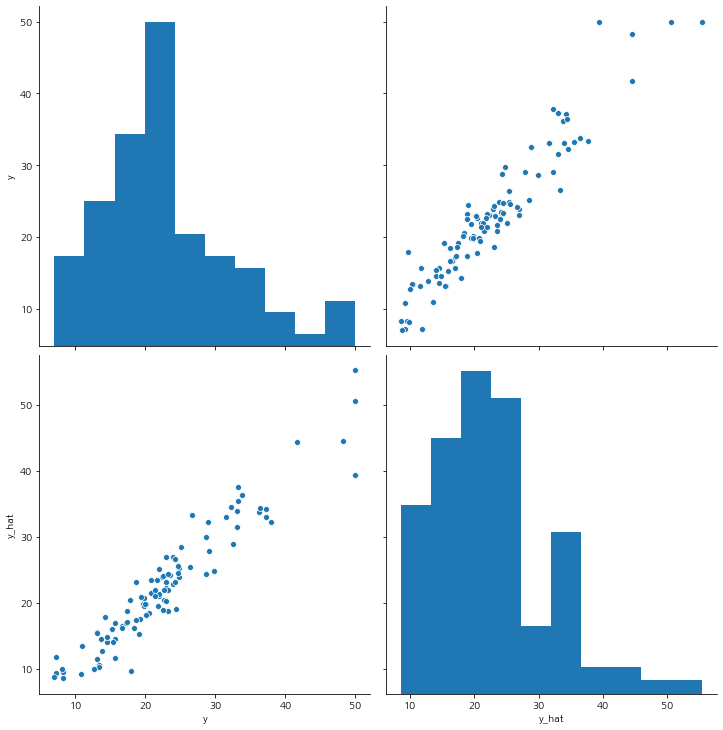

In [19]:
# 시각화
import seaborn as sns
sns.pairplot(df, height=5)
plt.show()

In [21]:
mse = np.sum((y.detach().numpy() - y_hat.detach().numpy())**2 ) / y.size(0)
print('Mean Squared Error:', mse)

Mean Squared Error: 7.812567018995098
